In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cv2

In [2]:
IMG_PATH = Path('/gws/nopw/j04/iecdt/computer-vision-data')
LABELS_PATH = Path('/gws/nopw/j04/iecdt/JERMIT_the_frog/')

In [3]:
labels = pd.read_csv(LABELS_PATH / 'hydrometeors_time_aligned_classes.csv', index_col=0)
dset_size = labels.shape[1]

In [4]:
def preprocess_img(img):
    img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def get_imgs(fname):
    img_a = cv2.imread(IMG_PATH / f'cam_a/compressed_rectified_imgs/{fname}.png')
    img_b = cv2.imread(IMG_PATH / f'cam_b/compressed_rectified_imgs/{fname}.png')
    return preprocess_img(img_a), preprocess_img(img_b)

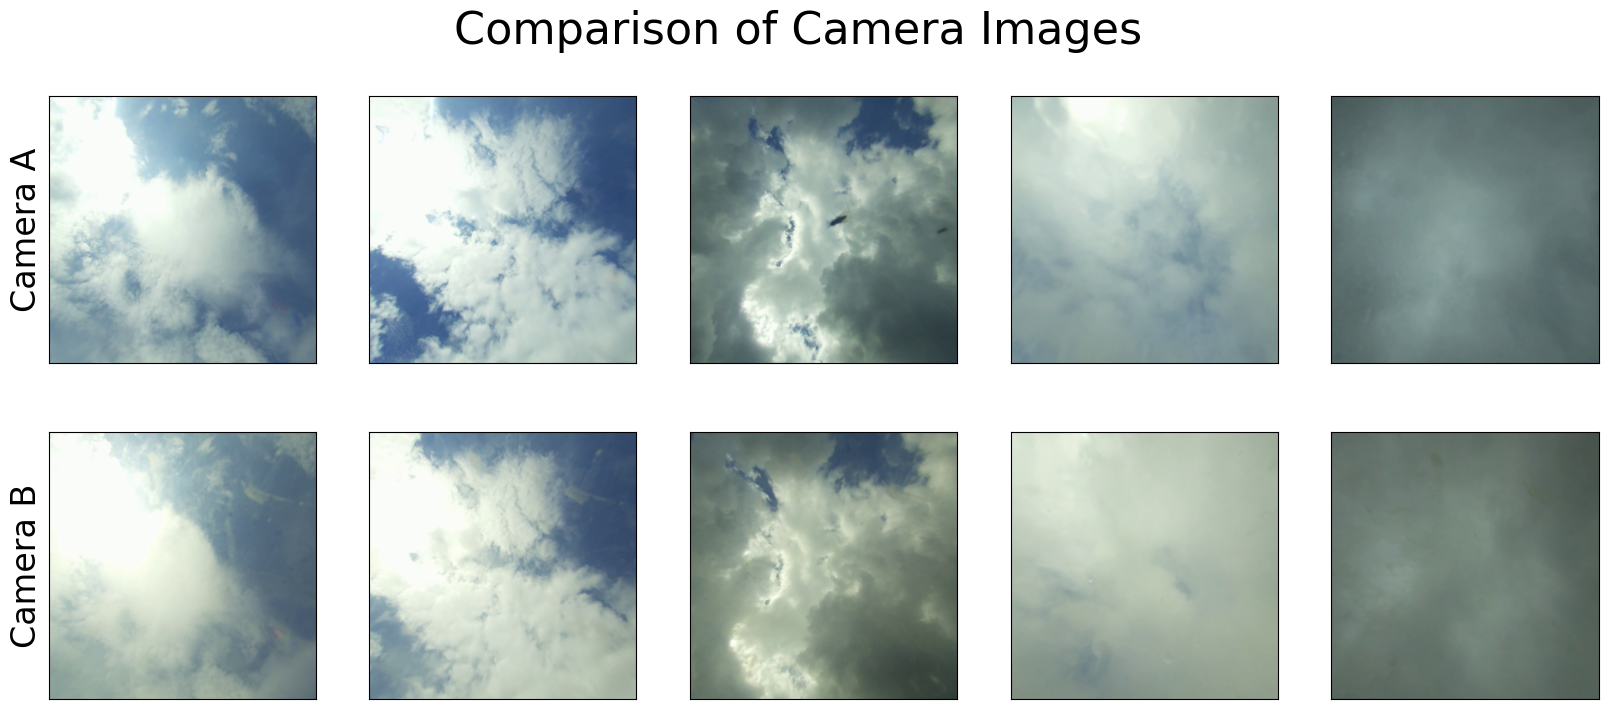

In [5]:
#Plot some matched examples from the rectified images with camera A on top and camera B on the bottom
fig, ax = plt.subplots(2, 5, figsize=(20, 8))
for axs in ax.flatten():
    axs.set_xticks([])
    axs.set_yticks([])
for i in range(5):
    n = np.random.randint(0,13760)
    img_A, img_B = get_imgs(labels.columns[n])
    ax[0,i].imshow(img_A)
    ax[1,i].imshow(img_B)

fig.suptitle("Comparison of Camera Images", fontsize=32)

row_titles = ["Camera A", "Camera B"]
for i, row in enumerate(ax):
    row[0].set_ylabel(row_titles[i], fontsize=24)

In [6]:
# Camera parameters (from calibration)
img_px_width = 3040
fov = 90
focal_length = img_px_width / (2 * np.tan(np.deg2rad(fov / 2)))  # Adjust based on your camera calibration
baseline = 271  # Distance between the cameras in meters

In [7]:
# StereoSGBM parameters
num_disparities = 16*4
blocksize = 5

In [8]:
sel_imgs = np.random.randint(0, 13760, size=5)
height_bins = labels.index.values

/tmp/ipykernel_181651/4024434235.py:47: RuntimeWarning: invalid value encountered in cast
  depth_vis = np.uint8(depth_vis)


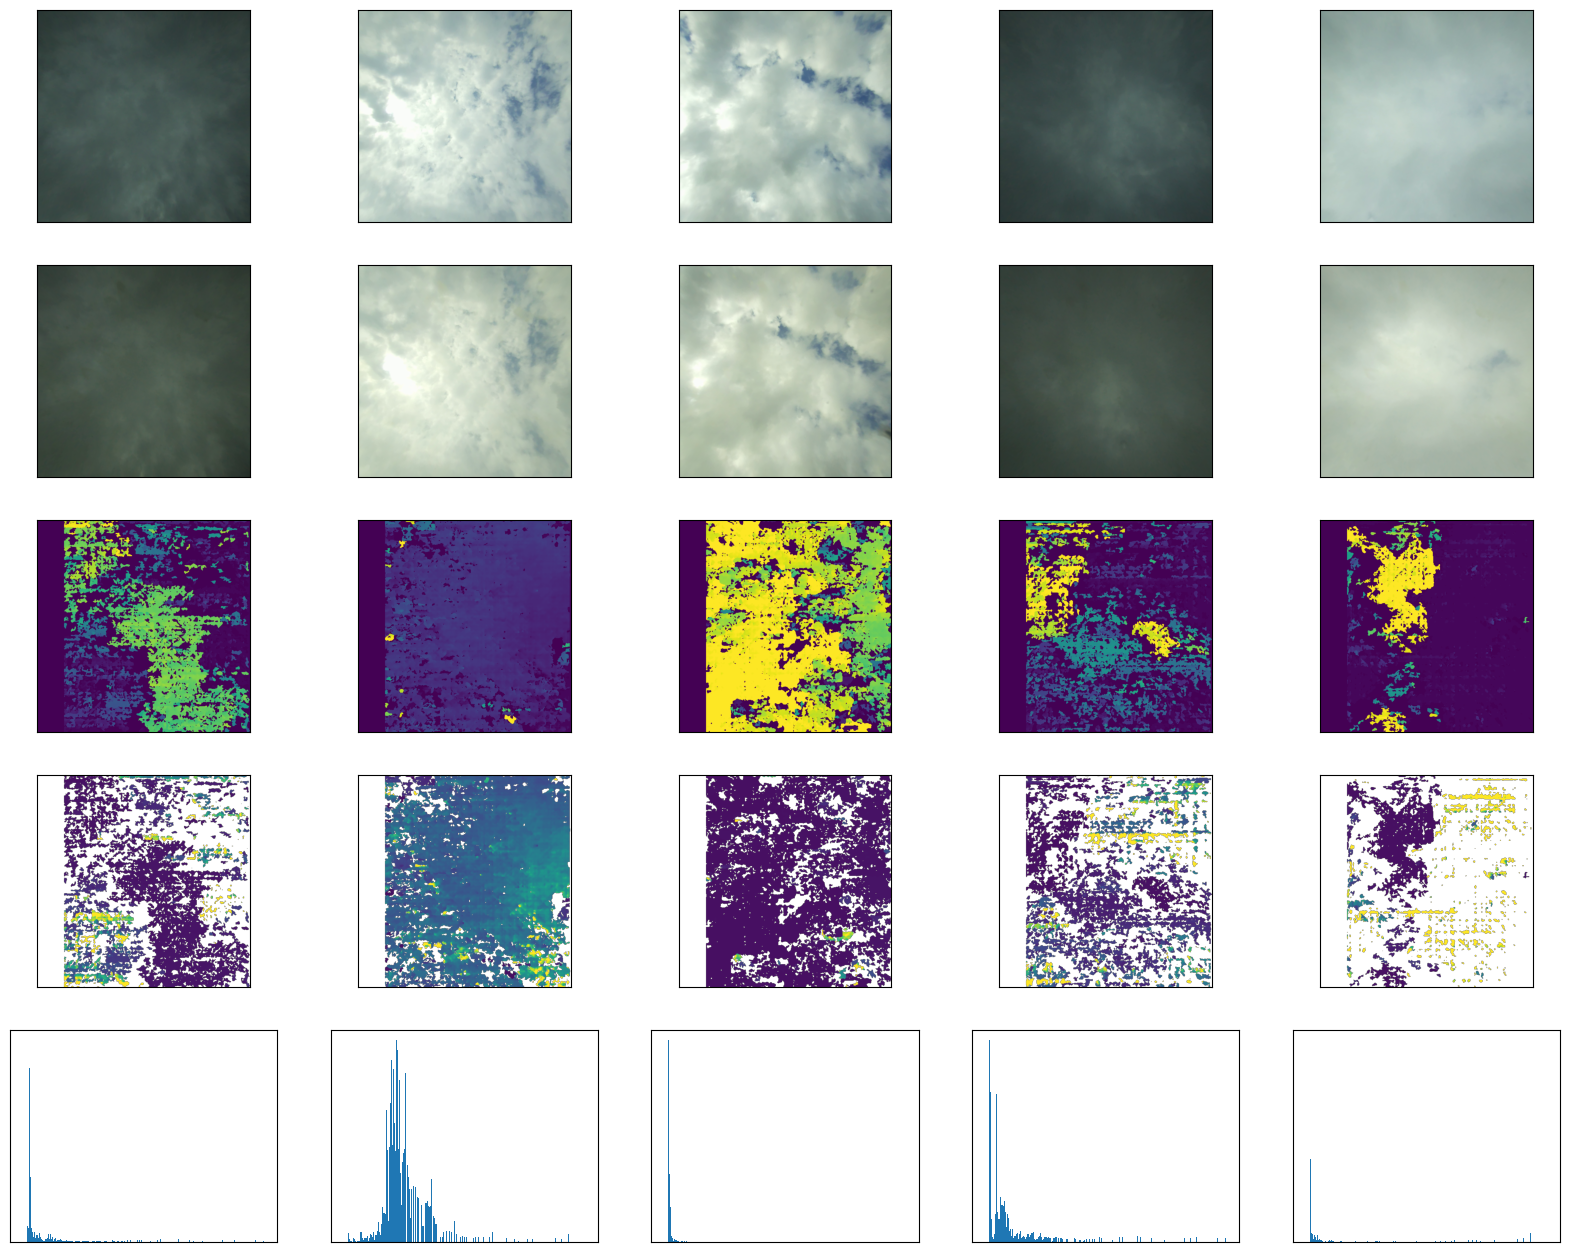

In [9]:
fig, ax = plt.subplots(5, 5, figsize=(20, 16))

for axs in ax.flatten():
    axs.set_xticks([])
    axs.set_yticks([])

for i, n in enumerate(sel_imgs):
    # Load stereo images (left and right)
    img_A, img_B = get_imgs(labels.columns[n])

    # Plot original rectified images
    ax[0,i].imshow(img_A)
    ax[1,i].imshow(img_B)

    # Create SGM matcher
    sgm = cv2.StereoSGBM_create(
        minDisparity=0,
        numDisparities=num_disparities,  # Should be a multiple of 16
        blockSize=blocksize,
        P1=8 * 3 * blocksize**2,  # 8 * number_of_channels * blockSize^2
        P2=32 * 3 * blocksize**2,
        disp12MaxDiff=7,
        uniquenessRatio=7,
        speckleWindowSize=50,
        speckleRange=3
    )

    # Compute disparity map
    disparity = sgm.compute(img_A, img_B)

    # Normalize and display
    disparity_norm = cv2.normalize(disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    disparity_vis = np.uint8(disparity_norm)

    ax[2,i].imshow(disparity_vis)

    # Disparity is set to float
    disparity = disparity.astype(np.float32)

    # Avoid division by zero
    disparity[disparity <= 0] = np.nan  # Prevent infinite depth

    depth_map = (focal_length * baseline) / disparity

    # Display depth map
    depth_vis = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)
    depth_vis = np.uint8(depth_vis)

    depth_norm = mcolors.Normalize(vmin=0, vmax=10000)
    ax[3,i].imshow(depth_map, cmap=plt.cm.viridis, norm=depth_norm)
    
    ax[4,i].hist(depth_map.flatten(), bins=height_bins)

In [11]:
sgm = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=num_disparities,  # Should be a multiple of 16
    blockSize=blocksize,
    P1=8 * 3 * blocksize**2,  # 8 * number_of_channels * blockSize^2
    P2=32 * 3 * blocksize**2,
    disp12MaxDiff=7,
    uniquenessRatio=7,
    speckleWindowSize=50,
    speckleRange=3
)

In [ ]:
for i in range(dset_size):
    img_A, img_B = get_imgs(labels.columns[i])
    disparity = sgm.compute(img_A, img_B)
    
    # Disparity is set to float
    disparity = disparity.astype(np.float32)

    # Avoid division by zero
    disparity[disparity <= 0] = np.nan  # Prevent infinite depth

    depth_map = (focal_length * baseline) / disparity

    counts, _ = np.histogram(depth_map.flatten(), bins=height_bins)
    y_pred = (counts >= 1).astype(int)
    y_pred == labels.iloc[:, 0].values
    break